### **Import the Libraries**

In [1]:
import pandas as pd 
import re 
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
from transformers import Trainer, TrainingArguments
from transformers import DistilBertTokenizerFast, DistilBertModel, TrainingArguments, Trainer
import torch
from torch import nn

### **Loading the dataset**

In [2]:
training_df = pd.read_csv("/kaggle/input/wysaai/NLP Engineer Assignment Dataset (1).xlsx - Train.csv")

In [3]:
training_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


**Shape of the training dataset**

In [4]:
#Shape of the Training Dataset
training_df.shape

(8589, 3)

**Value count of emotions**

In [5]:
#Value counts of Emotions
training_df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    5389
Positive emotion                      2672
Negative emotion                       519
I can't tell                             9
Name: count, dtype: int64

**Distribution**

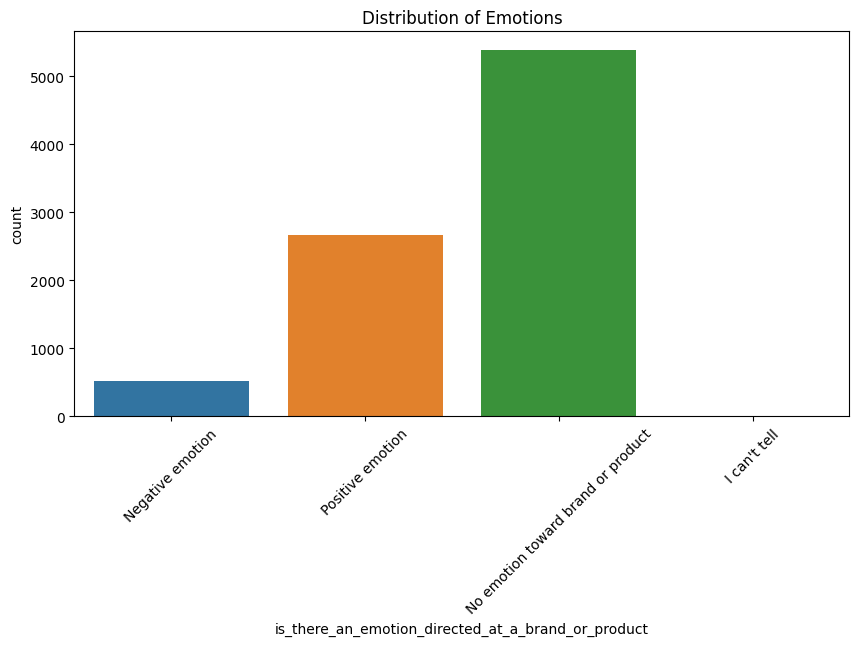

In [6]:
# Distribution of emotions
plt.figure(figsize=(10, 5))
sns.countplot(data=training_df, x='is_there_an_emotion_directed_at_a_brand_or_product')
plt.title('Distribution of Emotions')
plt.xticks(rotation=45)
plt.show()

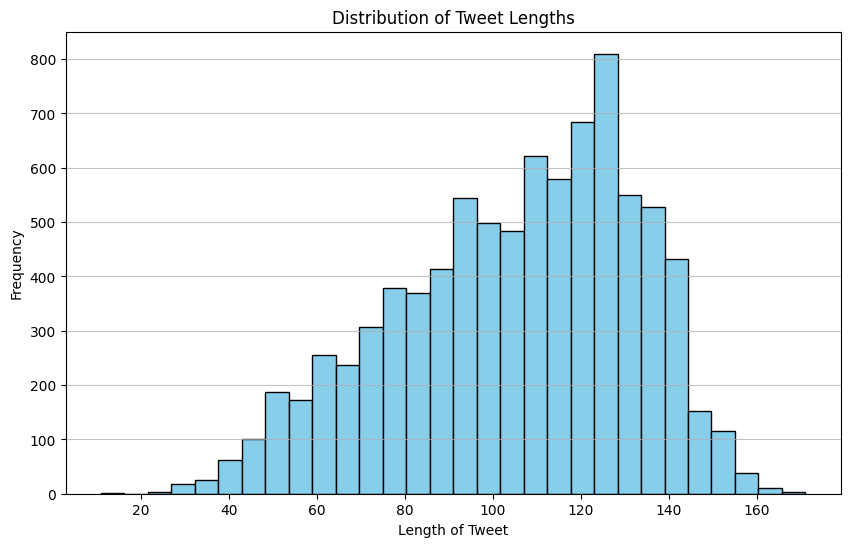

In [7]:
import matplotlib.pyplot as plt

# Plotting the distribution of tweet lengths directly
plt.figure(figsize=(10, 6))
plt.hist(training_df['tweet_text'].str.len(), bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Length of Tweet')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


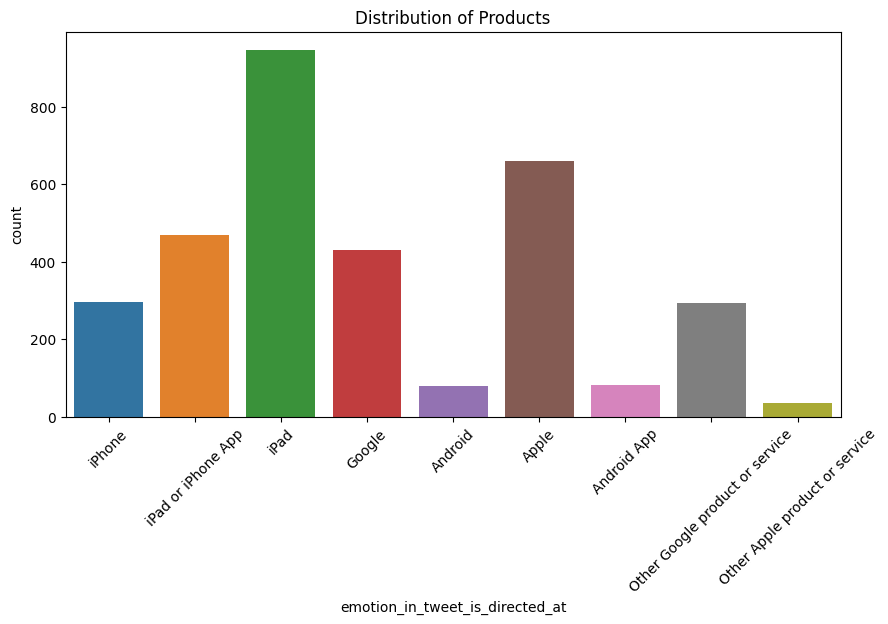

In [8]:
# Distribution of products
plt.figure(figsize=(10, 5))
sns.countplot(data=training_df, x='emotion_in_tweet_is_directed_at')
plt.title('Distribution of Products')
plt.xticks(rotation=45)
plt.show()

**Check Null Points**

In [9]:
training_df.isnull().sum()                                          

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5298
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [10]:
#Drop the Null Points in the tweets column
training_df = training_df.dropna(subset=['tweet_text'])

### **Label Encode the tweets text**

In [11]:
label_encoder = LabelEncoder()

In [12]:
training_df['labels'] = label_encoder.fit_transform(training_df['is_there_an_emotion_directed_at_a_brand_or_product'])

In [13]:
training_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,labels
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,1
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,3
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,3
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,1
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,3


### **Text Cleaning**

In [14]:
stop_words = stopwords.words('english')

def preprocess_data(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    cleaned_sentence = ' '.join(tokens)
    return cleaned_sentence

In [15]:
training_df['clean_text'] = training_df['tweet_text'].apply(preprocess_data)

In [16]:
training_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,labels,clean_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,1,wesley g iphone hrs tweeting riseaustin dead n...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,3,jessedee know fludapp awesome ipadiphone app y...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,3,swonderlin wait ipad also sale sxsw
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,1,sxsw hope years festival isnt crashy years iph...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,3,sxtxstate great stuff fri sxsw marissa mayer g...


In [17]:
from sklearn.model_selection import train_test_split 

# Split the dataset into training and evaluation sets (80% train, 20% eval)
train_df, eval_df = train_test_split(training_df, test_size=0.2, random_state=42)

# Convert DataFrame to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_df[['clean_text', 'labels']])
eval_dataset = Dataset.from_pandas(eval_df[['clean_text', 'labels']])

### **Testing Data**

In [18]:
testing_df = pd.read_csv("/kaggle/input/wysaai/NLP Engineer Assignment Dataset (1).xlsx - Test.csv")

In [19]:
testing_df.head()

,Tweet
0,Hand-Held ���Hobo�۪: Drafthouse launches ���Ho...
1,Again? RT @mention Line at the Apple store is ...
2,Boooo! RT @mention Flipboard is developing an ...
3,Thanks to @mention for publishing the news of ...
4,���@mention &quot;Apple has opened a pop-up st...


In [20]:
testing_df['Tweet'] = testing_df['Tweet'].apply(preprocess_data)

### **Tokenization**

In [21]:
from transformers import DistilBertTokenizer


In [98]:
tokenizer = DistilBertTokenizer.from_pretrained(
    'distilbert-base-uncased',
    attention_probs_dropout_prob=0.5,
    hidden_dropout_prob=0.5
)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [99]:
# Tokenize the dataset
def preprocess_function(examples):
    return tokenizer(examples['clean_text'], truncation=True, padding='max_length', max_length=128)

#tokenized_datasets = dataset.map(preprocess_function, batched=True)

# Tokenize the datasets
train_tokenized = train_dataset.map(preprocess_function, batched=True)
eval_tokenized = eval_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/6870 [00:00<?, ? examples/s]

Map:   0%|          | 0/1718 [00:00<?, ? examples/s]

In [100]:
#Prepare the dataset for training
#tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Prepare the datasets for training
train_tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
eval_tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [101]:
from transformers import DistilBertForSequenceClassification

# Specify the number of unique labels
num_labels = len(training_df['labels'].unique())

# Load the DistilBERT model for sequence classification
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=num_labels
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [102]:
from transformers import TrainingArguments, Trainer

# Define training arguments with modifications
training_args = TrainingArguments(
    output_dir='./distilbert_ticket_classification',
    evaluation_strategy='epoch',
    save_strategy='epoch',  # Match save strategy with evaluation strategy
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    learning_rate=0.001,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    report_to=["none"],
    save_total_limit=2,  
    warmup_ratio=0.1,  
    fp16=True 
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [103]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=eval_tokenized,
    compute_metrics=None 
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [104]:
#Start Training
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
1,0.870000,0.959410
2,0.852100,0.832857
3,0.849400,0.815361
4,0.834600,0.815695
5,0.838100,0.814050


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

TrainOutput(global_step=1075, training_loss=0.8545107783827671, metrics={'train_runtime': 279.9665, 'train_samples_per_second': 122.693, 'train_steps_per_second': 3.84, 'total_flos': 1137604359628800.0, 'train_loss': 0.8545107783827671, 'epoch': 5.0})

In [105]:
# Save the fine-tuned model
trainer.save_model('emotions_classification_funetined_model')

# Save the tokenizer
tokenizer.save_pretrained('emotions_classification_funetined_tokenizer')


('emotions_classification_funetined_tokenizer/tokenizer_config.json',
 'emotions_classification_funetined_tokenizer/special_tokens_map.json',
 'emotions_classification_funetined_tokenizer/vocab.txt',
 'emotions_classification_funetined_tokenizer/added_tokens.json')

In [114]:
from transformers import pipeline

# Load the fine-tuned model and tokenizer
classifier = pipeline("text-classification", model='emotions_classification_funetined_model', tokenizer='./emotions_classification_funetined_tokenizer')

# Example inference
sample_text = """
google brain apologies randy ads popping search results algorithm skewed weekend randy queries sxsw attendees
"""

predictions = classifier(sample_text)

# Decode the label
predicted_label = label_encoder.inverse_transform([int(predictions[0]['label'].split('_')[-1])])
print(f"Predicted label: {predicted_label[0]}")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Predicted label: No emotion toward brand or product


In [107]:
testing_df['clean_text'] = testing_df['Tweet'].apply(preprocess_data)

In [111]:
import pandas as pd

testing_df['predictions'] = testing_df['Tweet'].apply(lambda x: classifier(x)[0]['label'])

def decode_labels(predictions):
    try:
        # Extract label indices and decode them
        label_indices = [int(label.split('_')[-1]) for label in predictions]
        return label_encoder.inverse_transform(label_indices)
    except ValueError as e:
        print(f"Error decoding labels: {e}")
        return [None] * len(predictions)  

testing_df['predicted_tag'] = decode_labels(testing_df['predictions'])

# Save predictions to CSV
testing_df[['Tweet', 'predicted_tag']].to_csv('test_predictions.csv', index=False)

print("Predictions saved to test_predictions.csv")

Predictions saved to test_predictions.csv
